In [1]:
from __future__ import annotations

from pathlib import Path

import nshutils as nu
from jmp.lightning_datamodule import MPTrjAlexOMAT24DataModuleConfig

data_config = MPTrjAlexOMAT24DataModuleConfig.draft()
data_config.batch_size = 1
data_config.num_workers = 0
data_config.salex.local_path = Path("/storage/nima/salex-ocp/hf/")
data_config.omat24.local_path = Path("/storage/nima/omat24/hf/")

data_config.mptrj.enabled = False
data_config.salex.enabled = False
data_config.omat24.enabled = False

data_config.with_linear_reference_("mptrj-salex")
data_config = data_config.finalize()
nu.display(data_config)

In [2]:
from typing import Literal

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns


def plot_stress_histograms_plotly(
    data_dict,
    *,
    x_range=(-150, 150),
    nbins=None,
    opacity=0.75,
    title: str,
):
    """
    Create an interactive histogram plot using Plotly.

    Parameters:
    data_dict (dict): A dictionary where keys are labels and values are lists of stress data.
    x_range (tuple): The range for the x-axis (default: (-150, 150)).
    nbins (int): Number of bins for the histogram, or None to automatically determine the number of bins (default: None).
    opacity (float): Opacity of the histogram bars (default: 0.75).
    title (str): Title of the plot.

    Returns:
    plotly.graph_objects.Figure: The created figure object.
    """

    traces = []
    for label, stresses in data_dict.items():
        trace = go.Histogram(
            x=stresses,
            name=label,
            opacity=opacity,
            nbinsx=nbins,
            # histnorm="probability",  # Use raw counts instead of density
        )
        traces.append(trace)

    layout = go.Layout(
        title=title,
        xaxis=dict(title="Stress", range=x_range),
        yaxis=dict(title="Count"),
        barmode="overlay",
        legend=dict(
            x=1,
            y=1,
            bgcolor="rgba(255, 255, 255, 0.5)",
            bordercolor="rgba(0, 0, 0, 0.1)",
        ),
        template="plotly_white",
    )

    fig = go.Figure(data=traces, layout=layout)

    fig.update_layout(
        font=dict(family="Arial", size=14),
        plot_bgcolor="rgba(240, 240, 240, 0.95)",
        hovermode="closest",
    )

    return fig


def plot_stress_histograms_seaborn(
    data_dict,
    *,
    x_range=(-150, 150),
    bins: int | Literal["auto"] = "auto",
    kde=False,
    title: str,
):
    """
    Create a histogram plot using Seaborn.

    Parameters:
    data_dict (dict): A dictionary where keys are labels and values are lists of stress data.
    x_range (tuple): The range for the x-axis (default: (-150, 150)).
    bins (int): Number of bins for the histogram, or "auto" to automatically determine the number of bins (default: "auto").
    kde (bool): Whether to show the kernel density estimate (default: False).
    title (str): Title of the plot.

    Returns:
    matplotlib.figure.Figure: The created figure object.
    """

    fig, ax = plt.subplots(figsize=(10, 6))

    for label, stresses in data_dict.items():
        sns.histplot(stresses, ax=ax, label=label, bins=bins, kde=kde)

    ax.set_xlim(x_range)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Stress", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    ax.legend(fontsize=10)

    plt.tight_layout()
    return fig


def plot_both(
    data_dict,
    *,
    title: str,
    x_range=(-150, 150),
    nbins: int | Literal["auto"] = "auto",
    opacity=0.75,
):
    plot_stress_histograms_seaborn(
        data_dict,
        x_range=x_range,
        bins=nbins,
        title=title,
    ).show()
    plt.show()

    plot_stress_histograms_plotly(
        data_dict,
        x_range=x_range,
        nbins=None if nbins == "auto" else nbins,
        opacity=opacity,
        title=title,
    ).show()

In [20]:
import numpy as np
from jmp.lightning_datamodule import MPTrjAlexOMAT24DataModule
from tqdm.auto import tqdm


def get(name, num_samples: int = 10_000):
    data_config_ = data_config.model_copy(deep=True)
    getattr(data_config_, name).enabled = True

    dm = MPTrjAlexOMAT24DataModule(data_config_)
    dl = dm.train_dataloader()

    values = []
    for i, batch in tqdm(enumerate(dl), total=num_samples):
        if i >= num_samples:
            break

        stress = batch.stress.squeeze().cpu().numpy()  # (3, 3)
        # # Get the norm of the stress tensor
        # stress = np.linalg.norm(stress)
        # stress = stress[0, 0]  # S11
        values.append(stress)

    values = np.stack(values, axis=0)
    return values


mptrj_stresses = get("mptrj")
salex_stresses = get("salex")
omat24_stresses = get("omat24")

print(mptrj_stresses.shape, salex_stresses.shape, omat24_stresses.shape)

Using reference: tensor([  0.0000,  -3.1963,   0.0000,  -3.2290,  -3.4322,  -8.5496,  -8.2191,
         -7.8260,  -8.1598,  -5.4845,   0.0000,  -1.9239,  -2.7627,  -5.3121,
         -8.0203,  -6.0494,  -5.2393,  -3.7758,   0.0000,  -1.8893,  -3.7566,
         -6.7342, -10.5627,  -8.6279, -10.0481,  -9.3931,  -8.4282,  -6.4513,
         -5.5547,  -3.0273,  -1.0709,  -3.6285,  -5.1911,  -4.4706,  -4.4318,
         -3.2518,   0.0000,  -1.7896,  -3.4572,  -7.3412,  -9.8021, -11.5341,
         -9.8159,  -9.2127,  -8.4827,  -7.3640,  -5.4905,  -1.8031,  -0.6881,
         -2.7338,  -3.9818,  -3.9856,  -3.6631,  -2.2945,  12.6344,  -1.1320,
         -4.0098,  -6.0914,  -7.4939,  -4.7857,  -5.0797,  -4.3526,  -4.6100,
        -11.9252, -15.2658,  -4.7832,  -4.5034,  -4.5137,  -4.7774,  -4.2152,
         -4.6909,  -6.2142, -10.4472, -12.8089, -12.1459, -11.4949, -10.1591,
         -8.7412,  -6.3565,  -2.9478,   0.1396,  -2.0750,  -3.2368,  -3.2515,
          0.0000,   0.0000,   0.0000,   0.0000,

  0%|          | 0/10000 [00:00<?, ?it/s]

Using reference: tensor([  0.0000,  -3.1963,   0.0000,  -3.2290,  -3.4322,  -8.5496,  -8.2191,
         -7.8260,  -8.1598,  -5.4845,   0.0000,  -1.9239,  -2.7627,  -5.3121,
         -8.0203,  -6.0494,  -5.2393,  -3.7758,   0.0000,  -1.8893,  -3.7566,
         -6.7342, -10.5627,  -8.6279, -10.0481,  -9.3931,  -8.4282,  -6.4513,
         -5.5547,  -3.0273,  -1.0709,  -3.6285,  -5.1911,  -4.4706,  -4.4318,
         -3.2518,   0.0000,  -1.7896,  -3.4572,  -7.3412,  -9.8021, -11.5341,
         -9.8159,  -9.2127,  -8.4827,  -7.3640,  -5.4905,  -1.8031,  -0.6881,
         -2.7338,  -3.9818,  -3.9856,  -3.6631,  -2.2945,  12.6344,  -1.1320,
         -4.0098,  -6.0914,  -7.4939,  -4.7857,  -5.0797,  -4.3526,  -4.6100,
        -11.9252, -15.2658,  -4.7832,  -4.5034,  -4.5137,  -4.7774,  -4.2152,
         -4.6909,  -6.2142, -10.4472, -12.8089, -12.1459, -11.4949, -10.1591,
         -8.7412,  -6.3565,  -2.9478,   0.1396,  -2.0750,  -3.2368,  -3.2515,
          0.0000,   0.0000,   0.0000,   0.0000,

  0%|          | 0/10000 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/212 [00:00<?, ?it/s]

Using reference: tensor([  0.0000,  -3.1963,   0.0000,  -3.2290,  -3.4322,  -8.5496,  -8.2191,
         -7.8260,  -8.1598,  -5.4845,   0.0000,  -1.9239,  -2.7627,  -5.3121,
         -8.0203,  -6.0494,  -5.2393,  -3.7758,   0.0000,  -1.8893,  -3.7566,
         -6.7342, -10.5627,  -8.6279, -10.0481,  -9.3931,  -8.4282,  -6.4513,
         -5.5547,  -3.0273,  -1.0709,  -3.6285,  -5.1911,  -4.4706,  -4.4318,
         -3.2518,   0.0000,  -1.7896,  -3.4572,  -7.3412,  -9.8021, -11.5341,
         -9.8159,  -9.2127,  -8.4827,  -7.3640,  -5.4905,  -1.8031,  -0.6881,
         -2.7338,  -3.9818,  -3.9856,  -3.6631,  -2.2945,  12.6344,  -1.1320,
         -4.0098,  -6.0914,  -7.4939,  -4.7857,  -5.0797,  -4.3526,  -4.6100,
        -11.9252, -15.2658,  -4.7832,  -4.5034,  -4.5137,  -4.7774,  -4.2152,
         -4.6909,  -6.2142, -10.4472, -12.8089, -12.1459, -11.4949, -10.1591,
         -8.7412,  -6.3565,  -2.9478,   0.1396,  -2.0750,  -3.2368,  -3.2515,
          0.0000,   0.0000,   0.0000,   0.0000,

  0%|          | 0/10000 [00:00<?, ?it/s]

(10000, 3, 3) (10000, 3, 3) (10000, 3, 3)


In [42]:
# Convert stress units from kbar -> eV/Å³
mptrj_stresses_eV = mptrj_stresses * 1e-3 * 1e-24

1.6020506247997435e-43

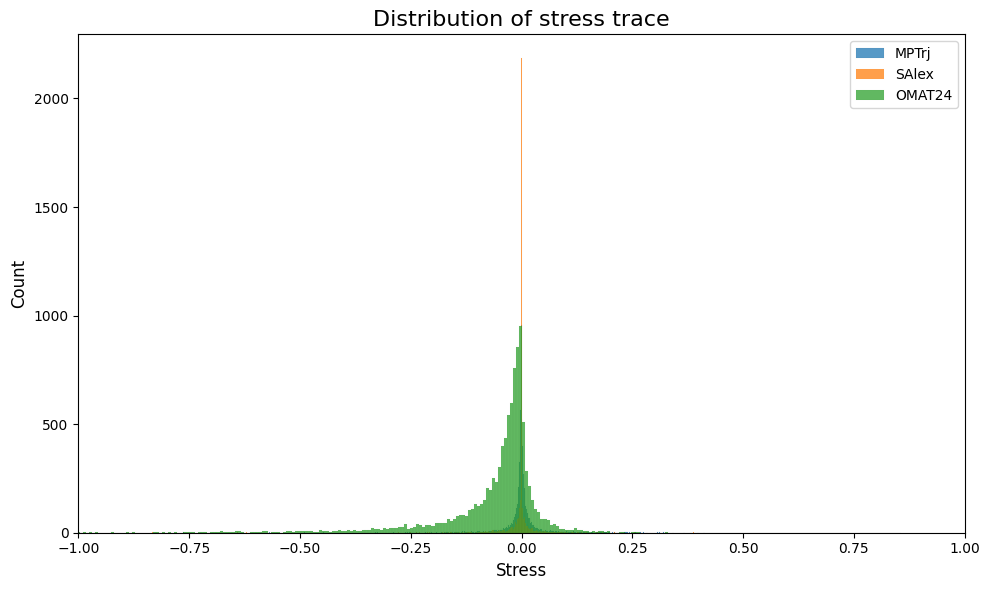

In [39]:
mptrj_stress_trace = np.trace(mptrj_stresses, axis1=1, axis2=2)
salex_stress_trace = np.trace(salex_stresses, axis1=1, axis2=2)
omat24_stress_trace = np.trace(omat24_stresses, axis1=1, axis2=2)
print(mptrj_stress_trace.shape, salex_stress_trace.shape, omat24_stress_trace.shape)

plot_both(
    {
        "MPTrj": mptrj_stress_trace,
        "SAlex": salex_stress_trace,
        "OMAT24": omat24_stress_trace,
    },
    # nbins=1000,
    x_range=(-1, 1),
    title="Distribution of stress trace",
)

(10000,) (10000,) (10000,)


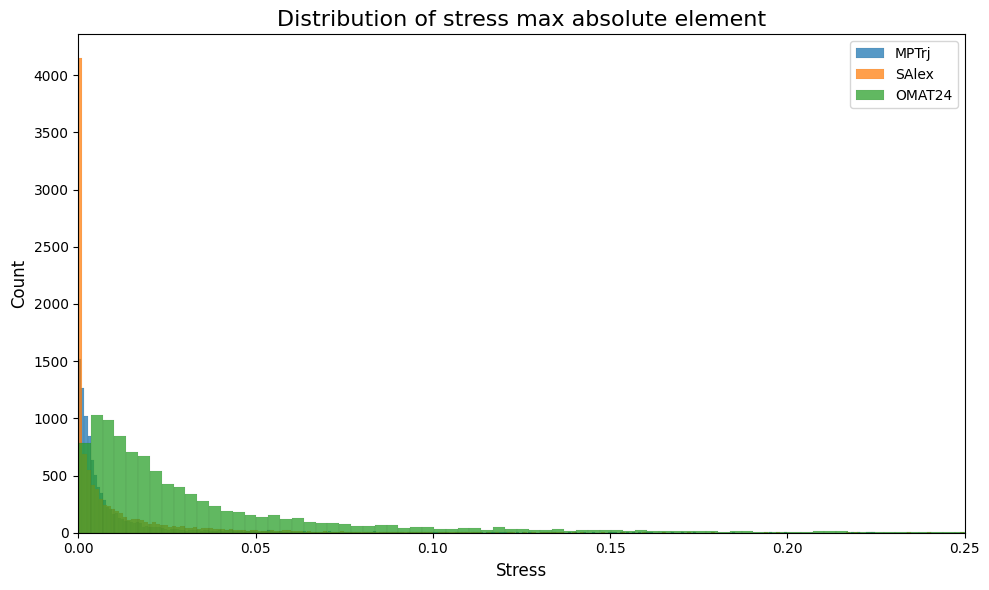

In [41]:
mptrj_stress_max_abs = np.abs(mptrj_stresses).max(axis=(1, 2))
salex_stress_max_abs = np.abs(salex_stresses).max(axis=(1, 2))
omat24_stress_max_abs = np.abs(omat24_stresses).max(axis=(1, 2))
print(
    mptrj_stress_max_abs.shape, salex_stress_max_abs.shape, omat24_stress_max_abs.shape
)

plot_both(
    {
        "MPTrj": mptrj_stress_max_abs,
        "SAlex": salex_stress_max_abs,
        "OMAT24": omat24_stress_max_abs,
    },
    # nbins=1000,
    x_range=(0, .25),
    title="Distribution of stress max absolute element",
)